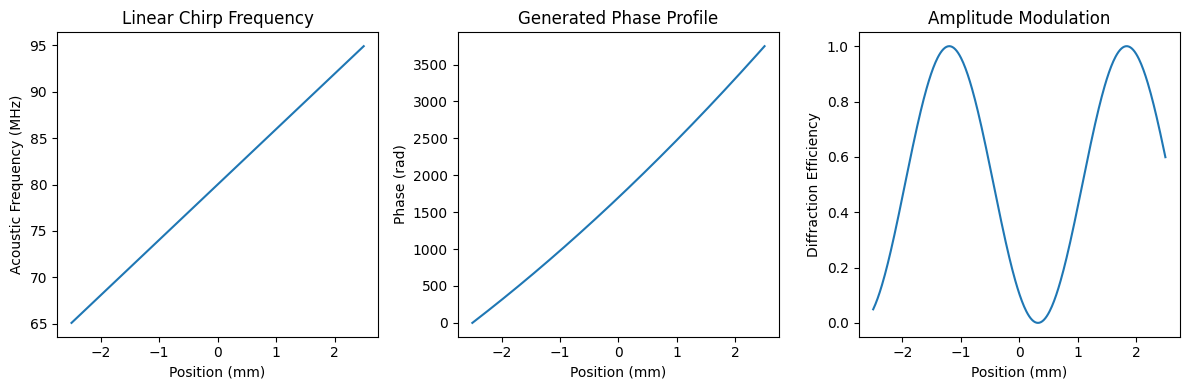

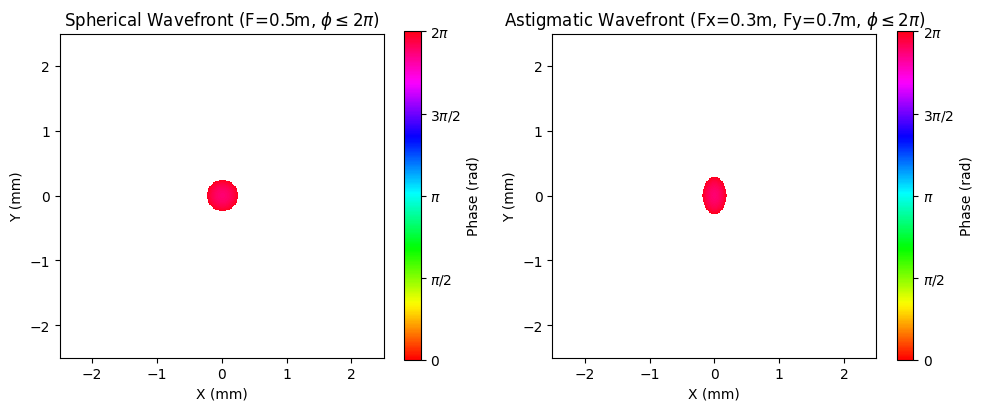

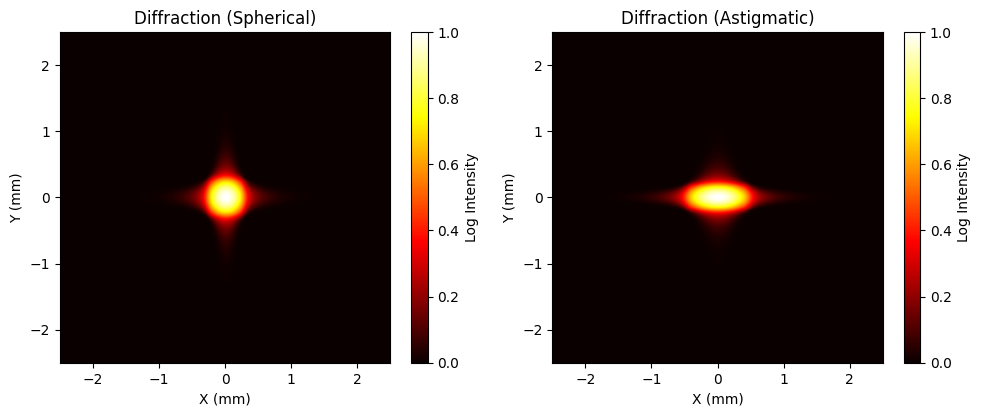

TypeError: astigmatism_wavefront() missing 1 required positional argument: 'delta'

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift

# 参数设置
wavelength = 1064e-9  # 波长 (m)
v_sound = 670  # TeO2中声速 (m/s)
aperture_size = 5e-3  # AOD孔径 (m)
N_pixels = 400  # 像素数 (文献值)
access_time = aperture_size / v_sound  # 访问时间 (s)
clock_rate = 14e6  # 时钟频率 (Hz)
f_center = 80e6  # 中心频率 80 MHz
f_min = 65e6     # 最小频率 65 MHz
f_max = 95e6     # 最大频率 95 MHz
f_bandwidth = f_max - f_min  # 带宽 30 MHz


# 生成AOD空间坐标
x = np.linspace(-aperture_size/2, aperture_size/2, N_pixels)
dx = x[1] - x[0]

def generate_linear_chirp(alpha):
    """生成线性调频声波频率函数 (式10)，限制在 65MHz-95MHz 范围内"""
    t = x / v_sound  # 时间坐标
    f_AOD = f_center + alpha * t  # 频率随时间线性变化（以中心频率为基准）
    return np.clip(f_AOD, f_min, f_max)  # 限制在 65MHz-95MHz 之间

def calculate_phase(f_AOD):
    """计算AOD产生的相位 (式4)"""
    phi = np.zeros_like(f_AOD)
    for i in range(1, len(x)):
        phi[i] = phi[i-1] + (2*np.pi/v_sound) * f_AOD[i-1] * dx
    # phi = [_ % (2*np.pi) for _ in phi]
    return phi

def aod_transfer_function(a_AOD):
    """AOD振幅传递函数 (文献未明确，假设为sin²)"""
    return np.sin(a_AOD)**2  # 假设衍射效率与声波振幅平方成正比

# 示例1：线性调频生成聚焦透镜
alpha = 4e12  # 调频率 (Hz/s)
f_AOD = generate_linear_chirp(alpha)
phi_AOD = calculate_phase(f_AOD)
amplitude = aod_transfer_function(f_AOD)  # 假设均匀振幅

# 绘制声波频率与相位
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(x*1e3, f_AOD/1e6)
plt.xlabel('Position (mm)')
plt.ylabel('Acoustic Frequency (MHz)')
plt.title('Linear Chirp Frequency')

plt.subplot(132)
plt.plot(x*1e3, phi_AOD)
plt.xlabel('Position (mm)')
plt.ylabel('Phase (rad)')
plt.title('Generated Phase Profile')

plt.subplot(133)
plt.plot(x*1e3, amplitude)
plt.xlabel('Position (mm)')
plt.ylabel('Diffraction Efficiency')
plt.title('Amplitude Modulation')
plt.tight_layout()
plt.show()

# 生成二维网格
y = np.linspace(-aperture_size/2, aperture_size/2, N_pixels)
X, Y = np.meshgrid(x, y)

# 示例2：生成球面波前（不取模）
def spherical_wavefront(F, delta):
    """球面波前 = X相位 + Y相位"""
    phi_total = (2 * np.pi / wavelength) * ((X**2 + Y**2) / (2 * (F + delta)) +delta )
    return phi_total

# 示例3：生成像散波前（不取模）
def astigmatism_wavefront(Fx, Fy, delta):
    """像散波前（部分可分离）"""
    phi_total = (2 * np.pi / wavelength) * (X**2 / (2 * (Fx + delta)) + Y**2 / (2 * (Fy + delta)) + delta)
    return phi_total

# 计算相位
phi_spherical = spherical_wavefront(0.5, 0.000001)  # 焦距 0.5m
phi_astig = astigmatism_wavefront(0.3, 0.7, 0.000001)  # Fx=0.3m, Fy=0.7m

# 创建掩码：只显示 phi_total <= 2π 的部分
mask_spherical = (phi_spherical <= 2 * np.pi)
mask_astig = (phi_astig <= 2 * np.pi)

# 应用掩码（超过 2π 的部分设为透明）
masked_spherical = np.ma.masked_where(~mask_spherical, phi_spherical)
masked_astig = np.ma.masked_where(~mask_astig, phi_astig)

# 可视化
plt.figure(figsize=(10, 4))

# 第一个子图：球面波前（仅显示 <=2π 部分）
plt.subplot(121)
im1 = plt.imshow(
    masked_spherical,
    extent=[x.min() * 1e3, x.max() * 1e3, y.min() * 1e3, y.max() * 1e3],
    cmap='hsv',
    vmin=0,
    vmax=2 * np.pi  # 限制颜色范围在 [0, 2π]
)
cb1 = plt.colorbar(im1, label='Phase (rad)')
ticks = np.arange(0, 2.1 * np.pi, np.pi / 2)  # 0, π/2, π, 3π/2, 2π
cb1.set_ticks(ticks)
cb1.set_ticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
plt.title('Spherical Wavefront (F=0.5m, $\phi \leq 2\pi$)')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')

# 第二个子图：像散波前（仅显示 <=2π 部分）
plt.subplot(122)
im2 = plt.imshow(
    masked_astig,
    extent=[x.min() * 1e3, x.max() * 1e3, y.min() * 1e3, y.max() * 1e3],
    cmap='hsv',
    vmin=0,
    vmax=2 * np.pi  # 限制颜色范围在 [0, 2π]
)
cb2 = plt.colorbar(im2, label='Phase (rad)')
cb2.set_ticks(ticks)
cb2.set_ticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
plt.title('Astigmatic Wavefront (Fx=0.3m, Fy=0.7m, $\phi \leq 2\pi$)')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')

plt.tight_layout()
plt.show()




def calculate_diffraction(phase_profile, amplitude_profile):
    """计算远场衍射图样（对数归一化）"""
    complex_field = amplitude_profile * np.exp(1j * phase_profile)
    field_fft = np.fft.fftshift(np.fft.fft2(complex_field))
    intensity = np.abs(field_fft)**2
    intensity_log = np.log10(1 + intensity)  # 对数变换
    intensity_normalized = intensity_log / np.max(intensity_log)  # 最大值归一化
    return intensity_normalized

# 生成振幅调制（示例：高斯光束）
amplitude_2d = np.exp(-(X**2 + Y**2)/(aperture_size/4)**2)

# 计算衍射图样
intensity_spherical = calculate_diffraction(phi_spherical, amplitude_2d)
intensity_astig = calculate_diffraction(phi_astig, amplitude_2d)

plt.figure(figsize=(10, 4))

# 第一个子图：球面波前的衍射图样
plt.subplot(121)
plt.imshow(
    intensity_spherical,
    cmap='hot',
    extent=[x.min()*1e3, x.max()*1e3, y.min()*1e3, y.max()*1e3],  # 坐标范围设为 mm
    origin='lower'  # 确保坐标原点在左下角（默认是左上角）
)
plt.title('Diffraction (Spherical)')
plt.colorbar(label='Log Intensity')
plt.xlabel('X (mm)')  # 标明坐标单位
plt.ylabel('Y (mm)')

# 第二个子图：像散波前的衍射图样
plt.subplot(122)
plt.imshow(
    intensity_astig,
    cmap='hot',
    extent=[x.min()*1e3, x.max()*1e3, y.min()*1e3, y.max()*1e3],  # 坐标范围设为 mm
    origin='lower'
)
plt.title('Diffraction (Astigmatic)')
plt.colorbar(label='Log Intensity')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')

plt.tight_layout()  # 自动调整子图间距
plt.show()


def zernike_match_index(mode_name, aod_approx):
    """计算Zernike模式匹配指数 (式11)"""
    # 此处简化：实际需展开为Zernike多项式系数
    error = np.sqrt(np.mean((mode_name - aod_approx)**2))
    match = 1 / (1 + error)
    return match

# 假设 X, Y 是网格坐标（未归一化）
aperture_size = 1.0  # 归一化因子（可根据实际情况调整）
X_norm = X / (aperture_size / 2)  # 归一化到 [-1, 1]
Y_norm = Y / (aperture_size / 2)  # 归一化到 [-1, 1]

# 计算 Noll index 5（垂直像散）
Z_astig = np.sqrt(6) * (X_norm**2 - Y_norm**2)
Z_astig_aod = astigmatism_wavefront(0.5, -0.5)  # AOD近似（表1中m=1）

print(f"Astigmatism Match Index: {zernike_match_index(Z_astig, Z_astig_aod):.2f}")